In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
 
from sklearn import metrics

from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from ast import literal_eval

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, model
from lob_data_utils.svm_calculation import lob_svm
import os
from scipy import stats


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_dir = 'res_svm'
should_savefig = False

In [3]:
results_files = os.listdir(data_dir)
df_res = pd.DataFrame()
for f in results_files:
    if 'csv' not in f:
        continue
    df_res = df_res.append(pd.read_csv(os.path.join(data_dir, f)))

df_res.drop(columns=['Unnamed: 0'], inplace=True)
df_res.head(4)

,C,coef0,f1,features,gamma,kappa,kernel,matthews,precision,recall,...,train_matthews,train_precision,train_recall,train_roc_auc,train_val_f1,train_val_kappa,train_val_matthews,train_val_precision,train_val_recall,train_val_roc_auc
0,0.001,NaN,0.394587,que,0.001,0.0,rbf,0.0,0.294036,0.6,...,0.0,0.511103,1.0,0.5,0.407651,0.0,0.0,0.308708,0.6,0.5
1,0.001,NaN,0.394587,que,0.010,0.0,rbf,0.0,0.294036,0.6,...,0.0,0.511103,1.0,0.5,0.407651,0.0,0.0,0.308708,0.6,0.5
2,0.001,NaN,0.394587,que,0.100,0.0,rbf,0.0,0.294036,0.6,...,0.0,0.511103,1.0,0.5,0.407651,0.0,0.0,0.308708,0.6,0.5
3,0.001,NaN,0.394587,que,1.000,0.0,rbf,0.0,0.294036,0.6,...,0.0,0.511103,1.0,0.5,0.407651,0.0,0.0,0.308708,0.6,0.5


In [4]:
df_best_rbf = df_res[df_res['kernel'] == 'rbf'].sort_values(
    by='matthews', ascending=False).groupby('stock').head(1)
df_best_lin = df_res[df_res['kernel'] == 'linear'].sort_values(
    by='matthews', ascending=False).groupby('stock').head(1)
df_best_sig = df_res[df_res['kernel'] == 'sigmoid'].sort_values(
    by='matthews', ascending=False).groupby('stock').head(1)

In [5]:
df_best = df_res.sort_values(by=['matthews', 'train_matthews'], ascending=False).groupby('stock').head(1)

## Distributions

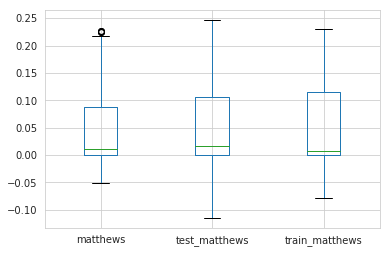

In [6]:
df_res[['matthews', 'test_matthews', 'train_matthews']].boxplot()

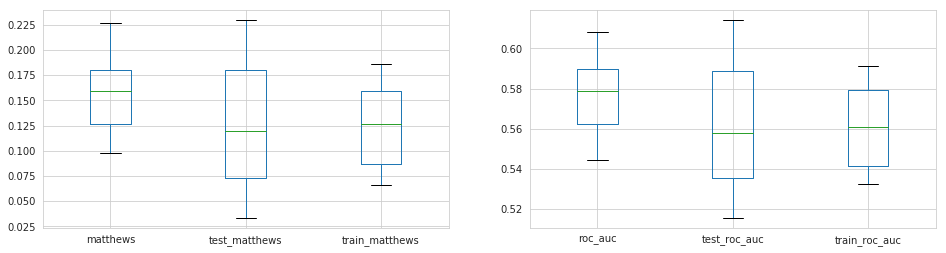

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
df_best[['matthews', 'test_matthews', 'train_matthews']].boxplot(ax=ax1)
df_best[['roc_auc', 'test_roc_auc', 'train_roc_auc']].boxplot(ax=ax2)

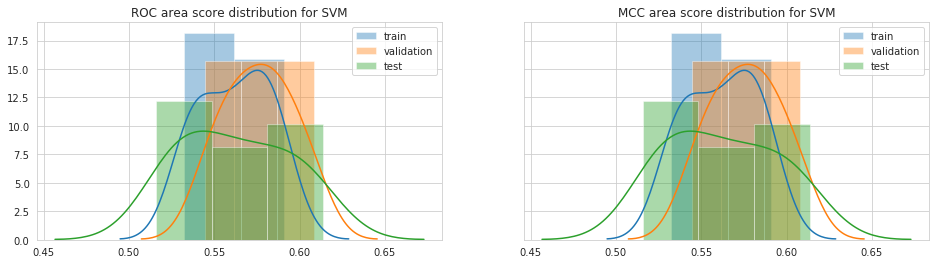

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)
sns.distplot(df_best[['train_roc_auc']], label='train', ax=ax1)
sns.distplot(df_best[['roc_auc']], label='validation', ax=ax1)
sns.distplot(df_best[['test_roc_auc']], label='test', ax=ax1)
ax1.set_title('ROC area score distribution for SVM')

sns.distplot(df_best[['train_roc_auc']], label='train', ax=ax2)
sns.distplot(df_best[['roc_auc']], label='validation', ax=ax2)
sns.distplot(df_best[['test_roc_auc']], label='test', ax=ax2)
ax2.set_title('MCC area score distribution for SVM')

ax1.legend()
ax2.legend()

### Per kernel

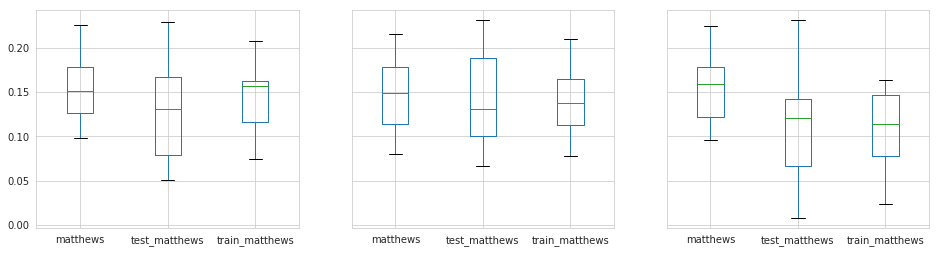

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
df_best_rbf[['matthews', 'test_matthews', 'train_matthews']].boxplot(ax=ax1)
df_best_lin[['matthews', 'test_matthews', 'train_matthews']].boxplot(ax=ax2)
df_best_sig[['matthews', 'test_matthews', 'train_matthews']].boxplot(ax=ax3)

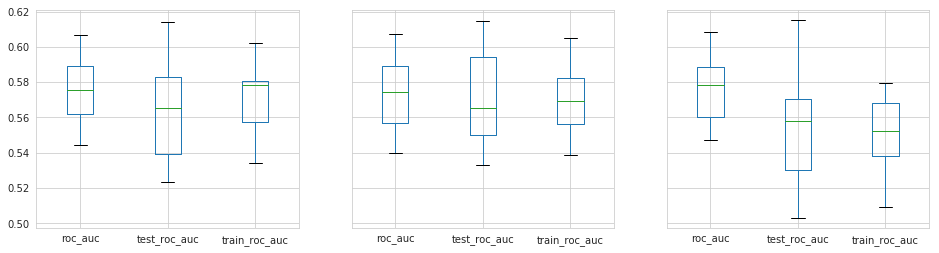

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
df_best_rbf[['roc_auc', 'test_roc_auc', 'train_roc_auc']].boxplot(ax=ax1)
df_best_lin[['roc_auc', 'test_roc_auc', 'train_roc_auc']].boxplot(ax=ax2)
df_best_sig[['roc_auc', 'test_roc_auc', 'train_roc_auc']].boxplot(ax=ax3)

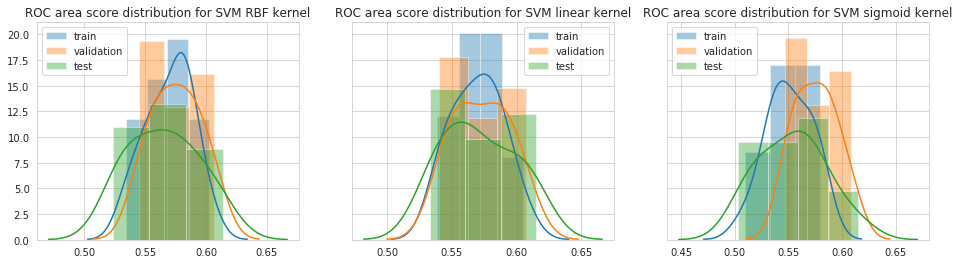

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
sns.distplot(df_best_rbf[['train_roc_auc']], label='train', ax=ax1)
sns.distplot(df_best_rbf[['roc_auc']], label='validation', ax=ax1)
sns.distplot(df_best_rbf[['test_roc_auc']], label='test', ax=ax1)
ax1.set_title('ROC area score distribution for SVM RBF kernel')

sns.distplot(df_best_lin[['train_roc_auc']], label='train', ax=ax2)
sns.distplot(df_best_lin[['roc_auc']], label='validation', ax=ax2)
sns.distplot(df_best_lin[['test_roc_auc']], label='test', ax=ax2)
ax2.set_title('ROC area score distribution for SVM linear kernel')

sns.distplot(df_best_sig[['train_roc_auc']], label='train', ax=ax3)
sns.distplot(df_best_sig[['roc_auc']], label='validation', ax=ax3)
sns.distplot(df_best_sig[['test_roc_auc']], label='test', ax=ax3)
ax3.set_title('ROC area score distribution for SVM sigmoid kernel')

ax1.legend()
ax2.legend()
ax3.legend()

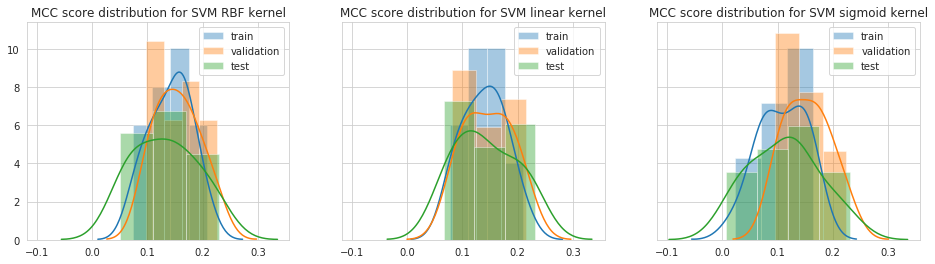

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), sharey=True, sharex=True)
sns.distplot(df_best_rbf[['train_matthews']], label='train', ax=ax1)
sns.distplot(df_best_rbf[['matthews']], label='validation', ax=ax1)
sns.distplot(df_best_rbf[['test_matthews']], label='test', ax=ax1)
ax1.set_title('MCC score distribution for SVM RBF kernel')

sns.distplot(df_best_lin[['train_matthews']], label='train', ax=ax2)
sns.distplot(df_best_lin[['matthews']], label='validation', ax=ax2)
sns.distplot(df_best_lin[['test_matthews']], label='test', ax=ax2)
ax2.set_title('MCC score distribution for SVM linear kernel')

sns.distplot(df_best_sig[['train_matthews']], label='train', ax=ax3)
sns.distplot(df_best_sig[['matthews']], label='validation', ax=ax3)
sns.distplot(df_best_sig[['test_matthews']], label='test', ax=ax3)
ax3.set_title('MCC score distribution for SVM sigmoid kernel')

ax1.legend()
ax2.legend()
ax3.legend()

### Distributions without sigmoid

In [13]:
df_ker = df_res[df_res['kernel'] != 'sigmoid']

df_ker = df_ker.sort_values(by='matthews', ascending=False).groupby('stock').head(1)

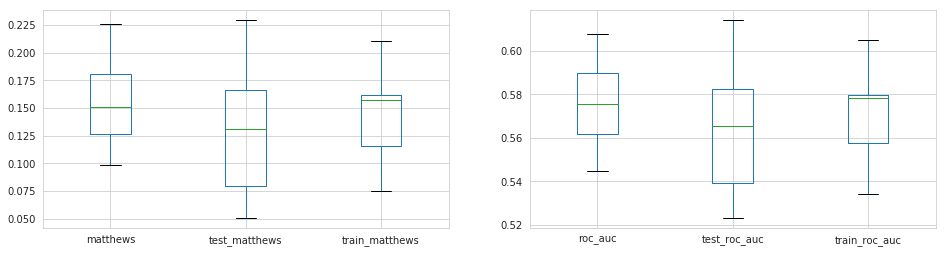

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
df_ker[['matthews', 'test_matthews', 'train_matthews']].boxplot(ax=ax1)
df_ker[['roc_auc', 'test_roc_auc', 'train_roc_auc']].boxplot(ax=ax2)

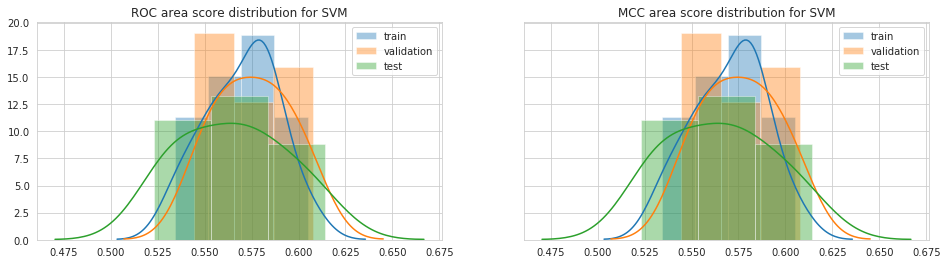

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)
sns.distplot(df_ker[['train_roc_auc']], label='train', ax=ax1)
sns.distplot(df_ker[['roc_auc']], label='validation', ax=ax1)
sns.distplot(df_ker[['test_roc_auc']], label='test', ax=ax1)
ax1.set_title('ROC area score distribution for SVM')

sns.distplot(df_ker[['train_roc_auc']], label='train', ax=ax2)
sns.distplot(df_ker[['roc_auc']], label='validation', ax=ax2)
sns.distplot(df_ker[['test_roc_auc']], label='test', ax=ax2)
ax2.set_title('MCC area score distribution for SVM')

ax1.legend()
ax2.legend()

## Compare with QUE+LOG

In [17]:
df_log = pd.read_csv('res_log_que.csv')
df_log.head()

,Unnamed: 0,f1,kappa,kernel,matthews,precision,recall,roc_auc,stock,test_f1,...,train_matthews,train_precision,train_recall,train_roc_auc,train_val_f1,train_val_kappa,train_val_matthews,train_val_precision,train_val_recall,train_val_roc_auc
0,9069,0.611399,0.094079,logistic,0.098751,0.548848,0.692501,0.546786,9069,0.596796,...,0.110846,0.562237,0.588394,0.555305,0.579891,0.105661,0.106075,0.563270,0.598326,0.552698
1,9063,0.569203,0.130577,logistic,0.131750,0.583475,0.560181,0.565503,9063,0.548865,...,0.129022,0.566616,0.561535,0.564510,0.552099,0.125123,0.125680,0.564415,0.542927,0.562434
2,1472,0.536240,0.138246,logistic,0.142472,0.597490,0.494417,0.569736,1472,0.639632,...,0.139034,0.576374,0.602151,0.569371,0.586165,0.146590,0.146806,0.575960,0.597133,0.573234
3,9094,0.566666,0.121811,logistic,0.123496,0.558923,0.579424,0.560737,9094,0.581147,...,0.115477,0.558185,0.564589,0.557733,0.565881,0.110139,0.110204,0.557783,0.574283,0.555050
4,9270,0.550921,0.098827,logistic,0.100080,0.572147,0.537000,0.549467,9270,0.569579,...,0.120107,0.560653,0.580020,0.560005,0.566821,0.128020,0.128312,0.564680,0.570270,0.563926


In [18]:
df_best = pd.merge(df_best, df_log, on='stock', suffixes=['', '_log'])
df_best.head()

,C,coef0,f1,features,gamma,kappa,kernel,matthews,precision,recall,...,train_matthews_log,train_precision_log,train_recall_log,train_roc_auc_log,train_val_f1_log,train_val_kappa_log,train_val_matthews_log,train_val_precision_log,train_val_recall_log,train_val_roc_auc_log
0,1000.0,NaN,0.607067,que,0.10,0.182704,rbf,0.184286,0.589457,0.629591,...,0.158845,0.586115,0.638081,0.578855,0.629547,0.157218,0.159011,0.591660,0.673028,0.577999
1,1.0,0.100,0.593195,que,0.01,0.176016,sigmoid,0.176423,0.595059,0.592683,...,0.149947,0.575668,0.584267,0.574960,0.590012,0.149390,0.149705,0.576846,0.604266,0.574603
2,100.0,0.001,0.605560,que,0.10,0.164047,sigmoid,0.171387,0.562494,0.668579,...,0.139001,0.569779,0.567500,0.569500,0.564292,0.126879,0.126922,0.565006,0.563767,0.563425
3,0.1,0.100,0.553544,que,1.00,0.156940,sigmoid,0.158722,0.595427,0.519025,...,0.134117,0.571696,0.599214,0.566919,0.601261,0.152424,0.152696,0.585041,0.618431,0.576073
4,1000.0,NaN,0.540676,que,10.00,0.140179,rbf,0.143583,0.531182,0.566853,...,0.126368,0.559875,0.543016,0.563134,0.584856,0.121642,0.122162,0.564357,0.607520,0.560701


In [19]:
df_best_lin = pd.merge(df_best_lin, df_log, on='stock', suffixes=['', '_log'])
df_best_rbf = pd.merge(df_best_rbf, df_log, on='stock', suffixes=['', '_log'])
df_best_sig = pd.merge(df_best_sig, df_log, on='stock', suffixes=['', '_log'])

In [20]:
def get_svm(x_train, y_label, kernel=None, C=None, gamma=None, coef0=None):
    clf = SVC(kernel=kernel, C=C, gamma=gamma, coef0=coef0)
    clf.fit(x_train, y_label)
    return clf

def get_svm_params(df, stock):
    df_stock = df[df['stock'] == int(stock)]
    C = df_stock['C'].values[0]
    gamma = df_stock['gamma'].values[0]
    coef0 = df_stock['coef0'].values[0]
    kernel = df_stock['kernel'].values[0]
    return {
        'C': C,
        'gamma': gamma,
        'coef0': coef0,
        'kernel': kernel
    }

def get_log(x_train, y_label):
    clf = LogisticRegression()
    clf.fit(x_train, y_label)
    return clf

In [27]:
stock = '9061'
data_length = 10000
df, df_test = lob.load_prepared_data(stock, data_dir='../data/prepared/', length=data_length)

preds = []
preds_log = []
for i in range(0, 30):
    clf = get_svm(df[['queue_imbalance']], df['mid_price_indicator'], **get_svm_params(df_best, stock))
    clf_log = get_log(df[['queue_imbalance']], df['mid_price_indicator'])
    pred = clf.predict(df_test[['queue_imbalance']])
    pred_log = clf_log.predict(df_test[['queue_imbalance']])
    preds.append(metrics.matthews_corrcoef(pred, df_test['mid_price_indicator'].values))
    preds_log.append(metrics.matthews_corrcoef(pred_log, df_test['mid_price_indicator'].values))

FileNotFoundError: File b'../data/prepared/9061.csv' does not exist

In [22]:
df_preds = pd.DataFrame()
df_preds['svm'] = preds
df_preds['log'] = preds_log
df_preds.head()

NameError: name 'preds' is not defined

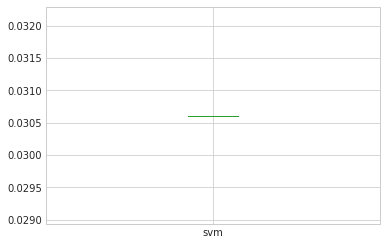

In [22]:
df_preds[['svm']].boxplot()

## McNemar's Test

In [23]:
def perform_mcnemar_test(stock):
    data_length = 10000
    df, df_test = lob.load_prepared_data(str(stock), data_dir='../gaussian_filter/data', 
                                         cv=False, length=data_length)

    clf = get_svm(df[['queue_imbalance']], df['mid_price_indicator'], **get_svm_params(df_best, stock))
    clf_log = get_log(df[['queue_imbalance']], df['mid_price_indicator'])
    pred = clf.predict(df_test[['queue_imbalance']])

    pred_log = clf_log.predict(df_test[['queue_imbalance']])
    #print(metrics.matthews_corrcoef(pred, df_test['mid_price_indicator'].values))
    #print(metrics.matthews_corrcoef(pred_log, df_test['mid_price_indicator'].values))

    [a, b], [c, d] = metrics.confusion_matrix(pred, pred_log)
    
    # print([a, b], [c, d])
    m = ((b - c) ** 2) / (b + c)
    return m

In [24]:
mcnemar_results = []
for stock in df_best['stock'].values:
    mcnemar_results.append(perform_mcnemar_test(stock))
df_best['mcnemar_results'] = mcnemar_results

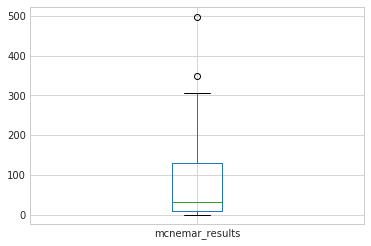

In [25]:
df_best[['mcnemar_results']].boxplot()

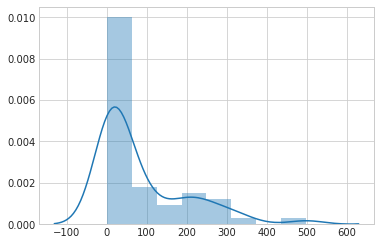

In [26]:
sns.distplot(df_best[['mcnemar_results']])

In [27]:
columns = ['stock', 'kernel'] + [c for c in df_best.columns if 'matthews' in c]
df_best[df_best['mcnemar_results'] < 3.84][columns]

,stock,kernel,matthews,test_matthews,train_matthews,train_val_matthews,matthews_log,test_matthews_log,train_matthews_log,train_val_matthews_log
2,3879,rbf,0.172178,0.113429,0.180155,0.180548,0.162258,0.113455,0.178407,0.174598
5,4799,sigmoid,0.164560,0.135467,0.145563,0.148094,0.166359,0.133334,0.144566,0.145488
15,5836,sigmoid,0.149604,-0.046914,-0.060836,0.132641,0.135863,0.136844,0.139954,0.144384
27,12456,sigmoid,0.138860,0.044843,0.069166,0.142732,0.120783,0.091759,0.133316,0.141260
39,9094,sigmoid,0.127536,0.070248,0.065454,0.104267,0.121154,0.137438,0.115477,0.110198
43,9067,sigmoid,0.122485,0.094088,0.099892,0.097373,0.116487,0.093134,0.101861,0.099216


### Regular comparision of scores

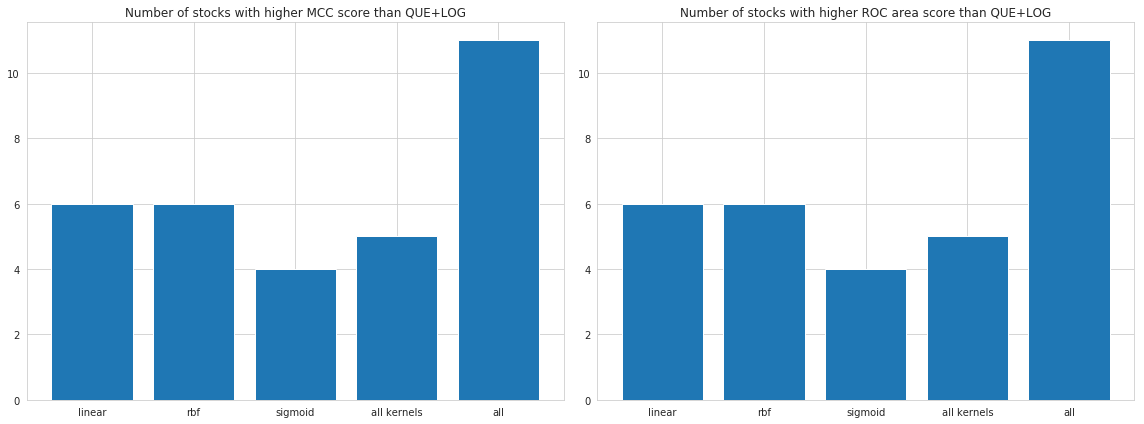

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

lin = len(df_best_lin[df_best_lin['test_matthews'] > df_best_lin['test_matthews_log']])
rbf = len(df_best_rbf[df_best_rbf['test_matthews'] > df_best_rbf['test_matthews_log']])
sig = len(df_best_sig[df_best_sig['test_matthews'] > df_best_sig['test_matthews_log']])
b = len(df_best[df_best['test_matthews'] > df_best['test_matthews_log']])
ax1.bar(['linear', 'rbf', 'sigmoid', 'all kernels', 'all'], [lin, rbf, sig, b, len(df_best_lin['stock'].unique())])
ax1.set_title('Number of stocks with higher MCC score than QUE+LOG')

lin = len(df_best_lin[df_best_lin['test_roc_auc'] > df_best_lin['test_roc_auc_log']])
rbf = len(df_best_rbf[df_best_rbf['test_roc_auc'] > df_best_rbf['test_roc_auc_log']])
sig = len(df_best_sig[df_best_sig['test_roc_auc'] > df_best_sig['test_roc_auc_log']])
b = len(df_best[df_best['test_roc_auc'] > df_best['test_roc_auc_log']])
ax2.bar(['linear', 'rbf', 'sigmoid', 'all kernels', 'all'], [lin, rbf, sig, b, len(df_best_lin['stock'].unique())])
ax2.set_title('Number of stocks with higher ROC area score than QUE+LOG')
plt.tight_layout()

## Case Study

In [29]:
stocks = ['9061', '9064', '9265']
df_case = df_res[df_res['kernel'] != 'sigmoid']
df_case = df_case.sort_values(by=['matthews'], ascending=False).groupby('stock').head(1)

In [30]:
columns = ['C', 'kernel', 'train_matthews', 'matthews', 'test_matthews', 'test_matthews_log', 'train_roc_auc', 
           'roc_auc', 'test_roc_auc', 'stock']
df_case = df_case[df_case['stock'].isin(stocks)]
df_case = pd.merge(df_case, df_log[df_log['stock'].isin(stocks)], on='stock', suffixes=['', '_log'])
df_case[columns]

,C,kernel,train_matthews,matthews,test_matthews,test_matthews_log,train_roc_auc,roc_auc,test_roc_auc,stock
0,100.0,rbf,0.098276,0.109428,0.061581,0.06052,0.548997,0.554331,0.530383,9061


In [31]:
df, df_test = lob.load_prepared_data('9061', data_dir='../gaussian_filter/data/')
df_test['mid_price'].plot()
df['mid_price'].plot()

FileNotFoundError: File b'../gaussian_filter/data/9061.csv' does not exist